## Machine Learning Model for Fraud Detection

### Objective
* Build machine learning models to accurately predict default for fraud detection, helping to make decisions on whether the loan should be approved

### Background 

* LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. Lending Club is the world's largest peer-to-peer lending platform. The company claims that 15.98 billion in loans had been originated through its platform up to December 31, 2015. Lending Club enables borrowers to create unsecured personal loans between 1,000 and 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

### Scenario Analysis

* Before a loan is issued to a borrower, lending club will collect information on a certain individual, generally including two aspects. The first one is personal information which includes age, sex, annual income, and etc. The second is information from third-party which includes FICO score, credit history, delinquency records, and etc. Lending club will then use a fraud detection model to predict whether this individual will default on loan, in order to make a final decision.

* First of all, we are interested in predicting whether the borrower will default on loans, which can be categorized as a binary classification problem. Therefore, supervised learning model should be used in this case.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')

import missingno as msno

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from pyecharts import Pie

pd.set_option('display.float_format', lambda x: '%.5f' % x)

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/lml/utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE 
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score, roc_curve, auc
import itertools

In [5]:
df = pd.read_csv('final_df.csv')
df.head()

,loan_amnt,int_rate,grade,open_acc,total_pymnt,total_rec_int,num_actv_rev_tl,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay,target
0,-0.58331,1.53492,1.34628,-0.24119,-0.44065,-0.51373,0.49473,1,0,0,...,0,1,0,0,1,0,1,1,0,0
1,0.40387,0.09784,0.48458,0.09319,-0.40326,-0.37036,1.36844,0,1,1,...,0,0,1,0,1,1,0,0,1,0
2,-0.18844,-0.39230,-0.37713,0.09319,-0.48192,-0.71458,-0.08773,0,1,1,...,1,0,0,1,0,1,0,1,0,0
3,-0.78075,-1.12359,-1.23884,0.59476,-0.50836,-0.99838,-0.67020,1,0,1,...,1,0,0,0,1,1,0,1,0,0
4,0.60131,0.96244,1.34628,-0.40838,-0.35554,0.00418,0.49473,0,1,0,...,0,1,0,1,0,1,0,0,1,0


In [7]:
count = [i for i in df.target.value_counts()]
attr = ['Normal','Default']
pie = Pie('Percentage of Default loans')
pie.add('', attr, count, is_label_show = True)
pie

* Most machine learning classification algorithms are sensitive to unbalance in the predictor classes. In our case, only 2% of the cases are default. A naive model that predicts all cases as non-fraud will give a high accuracy of 98% percent. However, such a model is useless to us. An unbalanced dataset will bias the prediction model towards the more common class. Therefore, we need to look at other metrics such as precision, recall, F1-score to evaluate model performance.

In [129]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

### Without Sampling

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 123)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

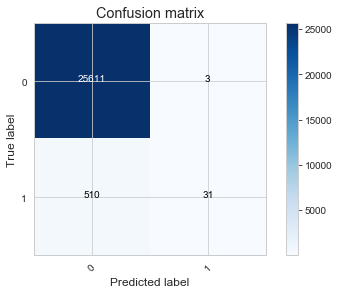

Precision =     0.912
Recall (TPR) =  0.057
Fallout (FPR) = 0.000


In [131]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

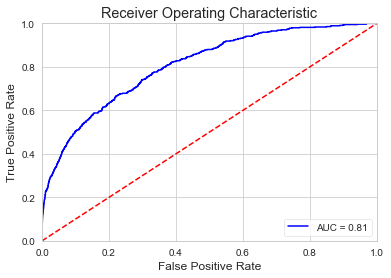

In [209]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

* There are in general two ways to address unbalance:
    * **Oversampling**: Increase fraud cases
    * **Undersamling**: Reduce some of the normal cases

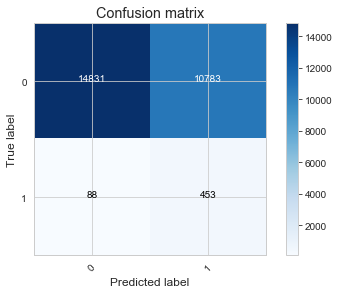

Precision =     0.040
Recall (TPR) =  0.837
Fallout (FPR) = 0.421


In [230]:
thresh = 0.012
y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

### Oversampling

* Finding the k-nearest-neighbors for minority class observations (finding similar observations)
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

In [134]:
X = df.iloc[:,:-1]
y = df['target']

In [135]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

In [136]:
sm = SMOTE(random_state = 42)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

print("After SMOTE to balance pos and neg cases:")
print('sample size: {}; Fraud: {:.2%}; Normal: {:.2%}'.format(
    X_smote.shape[0],
    y_smote[y_smote == 1].shape[0] / X_smote.shape[0],
    y_smote[y_smote == 0].shape[0] / X_smote.shape[0]
))

After SMOTE to balance pos and neg cases:
sample size: 205030; Fraud: 50.00%; Normal: 50.00%


### Logistic Regression

In [137]:
lr1 = LogisticRegression()
lr1.fit(X_smote, y_smote)
y_pred = lr1.predict(X_test)

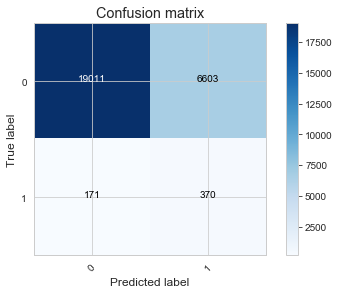

Precision =     0.053
Recall (TPR) =  0.684
Fallout (FPR) = 0.258


In [138]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

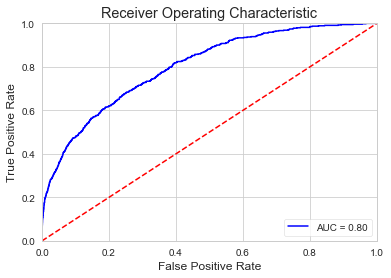

In [139]:
probs = lr1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression with Regularization

* Grid Search
* Random Search
* Bayesian optimization

In [182]:
from sklearn.model_selection import GridSearchCV

# Use L1 and L2 regularization to prevent overfitting
param_grid = {
    'C': np.linspace(1,10,10),
    'penalty':['l1','l2']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid_search.fit(X_smote, y_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [183]:
results = pd.DataFrame(grid_search.cv_results_)
best = np.argmax(results.mean_test_score.values)

print('Best Parameter:{}'.format(grid_search.best_params_))
print('Best cross-validation score: {:.5f}'.format(grid_search.best_score_))

Best Parameter:{'C': 9.0, 'penalty': 'l1'}
Best cross-validation score: 0.73033


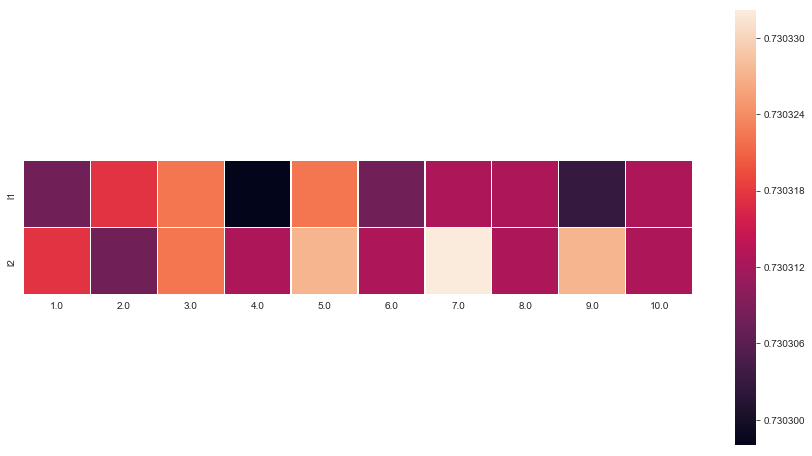

In [184]:
plt.figure(figsize = (15,8))
scores = np.array(results.mean_test_score).reshape(2,10)
sns.heatmap(scores, yticklabels = param_grid['penalty'], xticklabels = param_grid['C'], linewidths = 0.1, square = True)
plt.show()

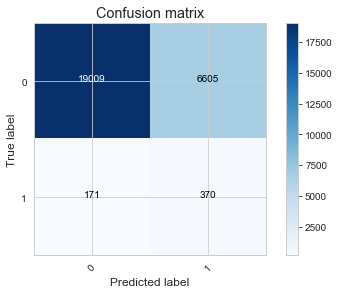

Precision =     0.053
Recall (TPR) =  0.684
Fallout (FPR) = 0.258


In [185]:
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

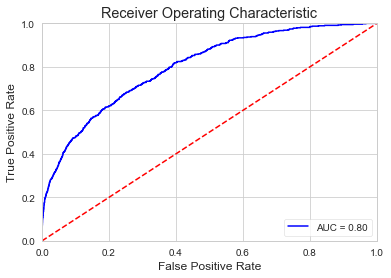

In [187]:
# calculate the fpr and tpr for all thresholds of the classification
probs = grid_search.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree

In [145]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 5)

dt.fit(X_smote, y_smote)
y_pred = dt.predict(X_test)

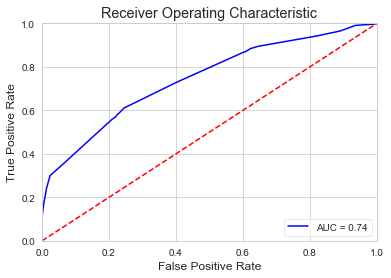

In [146]:
# calculate the fpr and tpr for all thresholds of the classification
probs = dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

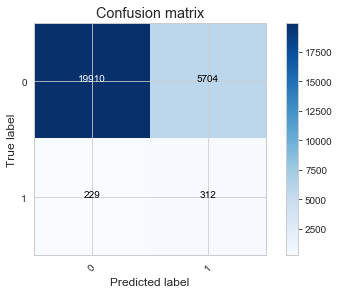

Precision =     0.052
Recall (TPR) =  0.577
Fallout (FPR) = 0.223


In [147]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

### Gradient Boosting 

In [188]:
from sklearn import ensemble
params = {'n_estimators':500, 'max_depth':3, 'subsample':0.5,
         'learning_rate':0.1, 'min_samples_leaf':1, 'random_state':3}

ens = ensemble.GradientBoostingClassifier(**params)
ens.fit(X_smote, y_smote)

y_pred = ens.predict(X_test)

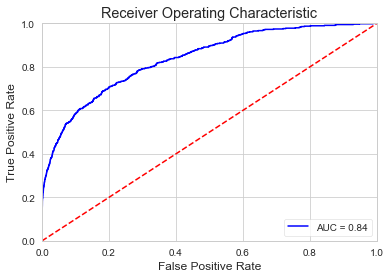

In [191]:
# calculate the fpr and tpr for all thresholds of the classification
probs = ens.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

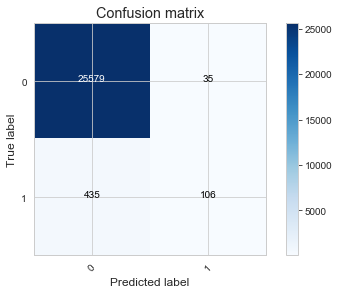

Precision =     0.752
Recall (TPR) =  0.196
Fallout (FPR) = 0.001


In [194]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

### Xgboost

#### Baseline boosting

In [197]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [205]:
xg = XGBClassifier()
xg.fit(X_train,y_train, eval_metric = ['error'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [206]:
y_pred = xg.predict(X_test)

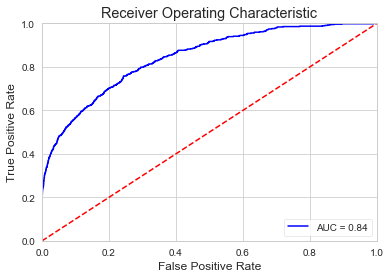

In [207]:
# calculate the fpr and tpr for all thresholds of the classification
probs = xg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

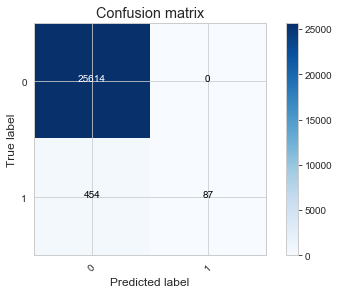

Precision =     1.000
Recall (TPR) =  0.161
Fallout (FPR) = 0.000


In [208]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);